# Audio Event Recognition Using Decision Trees

The subject Audio Event is a laundry appliance end-of-cycle beep sequence. Audio recordings were made of the appliance in operation including the beep sequence. Most of the recording was of the machine performing its normal function as well as "room tone". Room tone includes other household and environmental sounds picked up by the recorder.

The purpose of training a model in this notebook is to detect the beep itself and not the time sequence of beeps. That will be looked at in subsequent notebooks.

Audio data has been prepared in other notebooks for use in this machine learning training.

The audio recordings were resampled to 16kHz, amplitude normalised to within +/- 1.0 peak, divided into one minute segments and a discrete Fast Fourier Transform (FFT) analysis was performed. A sliding window of 150ms was used for FFT observation with a stride of 5ms.

This resulted in each observation comprising 2400 features which represent the frequency power level (dB) between 0 and 8kHz.

# Data File Setup
Configure the folder settings and helper function for loading data files.

In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd

from os.path import isfile, join

wav_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/parts/'
fft_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/fft/'

def list_files(base_dir, ext):
    onlyfiles = [f for f in os.listdir(base_dir) if isfile(join(base_dir, f)) and f.split('.')[-1] == ext]
    return np.sort(onlyfiles)

print('Compressed FFT Files:')
fft_compressed_files = list_files(fft_directory,'gz')
print(fft_compressed_files)

print('Response Files:')
fft_response_files = list_files(fft_directory,'csv')
print(fft_response_files)

Compressed FFT Files:
['161225-000_16bit-part-0.wav-fft.csv.gz'
 '161225-000_16bit-part-1.wav-fft.csv.gz'
 '161225-000_16bit-part-2.wav-fft.csv.gz'
 '161225-000_16bit-part-3.wav-fft.csv.gz'
 '161225-000_16bit-part-4.wav-fft.csv.gz'
 '161225-000_16bit-part-5.wav-fft.csv.gz'
 '161225-000_16bit-part-6.wav-fft.csv.gz'
 '161225-001_16bit-part-0.wav-fft.csv.gz'
 '161225-001_16bit-part-1.wav-fft.csv.gz'
 '161225-001_16bit-part-10.wav-fft.csv.gz'
 '161225-001_16bit-part-2.wav-fft.csv.gz'
 '161225-001_16bit-part-3.wav-fft.csv.gz'
 '161225-001_16bit-part-4.wav-fft.csv.gz'
 '161225-001_16bit-part-5.wav-fft.csv.gz'
 '161225-001_16bit-part-6.wav-fft.csv.gz'
 '161225-001_16bit-part-7.wav-fft.csv.gz'
 '161225-001_16bit-part-8.wav-fft.csv.gz'
 '161225-001_16bit-part-9.wav-fft.csv.gz'
 '161225-002_16bit-part-0.wav-fft.csv.gz'
 '161225-003_16bit-part-0.wav-fft.csv.gz'
 '161225-004_16bit-part-0.wav-fft.csv.gz'
 '161225-005_16bit-part-0.wav-fft.csv.gz'
 '161225-006_16bit-part-0.wav-fft.csv.gz'
 '161225-00

# Read Training Data Set
Use file `161225-001_16bit-part-9.wav` as the example which contains a beep sequence at the end with general washing machine and room noise elsewhere.

In [2]:
fft_compressed_file = fft_directory+'161225-001_16bit-part-9.wav-fft.csv.gz'
fft_response_file = fft_directory+'161225-001_16bit-part-9.wav-fft.csv.gz-response.csv'

# Load data as Pandas DataFrames
fft_data = pd.read_csv(fft_compressed_file).astype(np.float32)
fft_response = pd.read_csv(fft_response_file).astype(np.int)['response']

print(fft_data.head())
print(fft_response.head())

           0          1          2         3          4         5         6  \
0  26.209188  21.623608 -10.358844  6.586753  -7.028095  1.600575 -2.595378   
1  26.235340  21.709356  -9.568472  6.962870 -13.328078  2.581967 -9.131612   
2  26.278463  21.769438  -9.452969  6.770949 -39.410057 -4.097223  1.389082   
3  26.309322  21.846579  -9.775924  5.997091 -23.744251 -7.712294  1.630375   
4  26.332802  21.924908 -11.068607  5.241501 -25.522110  0.960066 -5.601819   

          7         8         9    ...           2390       2391       2392  \
0  6.081511  3.267589  2.665153    ...     -80.474724 -56.087372 -67.076408   
1  7.777575 -4.011588  3.869437    ...     -66.687279 -61.855881 -57.571312   
2  0.777063  7.331400 -0.322932    ...     -61.135799 -71.700638 -56.820793   
3  1.119996  7.259189 -7.944921    ...     -69.064392 -59.416782 -61.496887   
4  7.842555 -6.098834  6.155301    ...     -63.785179 -58.053242 -86.751587   

        2393       2394       2395       2396     

In [3]:
# Output the shape of the FFT DataFrame. Each observation contains 2400 frequency dB power levels up to 8kHz
fft_data.shape

(11970, 2400)

In [4]:
# The response counts for observation labels
fft_response.value_counts()

0    11515
1      455
Name: response, dtype: int64

# Helper Functions

In [5]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score

# cross validate a dataset
def cross_validate(features, target, classifier, numfolds=10, numrepeats=1):
    auc = [None] * (numfolds * numrepeats)
    logloss = [None] * (numfolds * numrepeats)
    seed = 1

    for r in range(numrepeats):
        seed = seed + 1
        offset = numfolds * (r - 1)
        kfold = StratifiedKFold(n_splits=numfolds, shuffle=True, random_state=seed)
    
        for i, (train_indices, test_indices) in enumerate(kfold.split(features,target)):
            classifier.fit(features.iloc[train_indices], target.iloc[train_indices])
            probabilities = classifier.predict_proba(features.iloc[test_indices])
            auc[i+offset] = metrics.roc_auc_score(target.iloc[test_indices], probabilities[:, 1])
            logloss[i+offset] = metrics.log_loss(target.iloc[test_indices], probabilities[:, 1])
        
    mean_auc = np.mean(auc)
    std_auc = np.std(auc)
    mean_logloss = np.mean(logloss)
    std_logloss = np.std(logloss)

    return mean_auc, std_auc, mean_logloss, std_logloss

# print the metrics from the outcome of a ML prediction
def print_metrics(target, predictions, probabilities):
    print(metrics.classification_report(target, predictions))
    print ('Logloss: {}'.format(metrics.log_loss(target, probabilities)))
    print ("AUC from ROC: {}".format(metrics.roc_auc_score(target, probabilities)))
    print ("\nConfusion matrix: ")
    print (metrics.confusion_matrix(target, predictions))
    
def plotROC(y_test, probabilities, title='Decision Tree'):
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib
    from sklearn import metrics

    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probabilities[:,1])
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.figure()
    plt.title('Receiver Operating Characteristics for %s'%title)
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_estimator_learning_curve(estimator, title='Learning Curve', ylim=(0.5, 1.01)):
    seed=1
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    plot_learning_curve(estimator, title, X_train, y_train, ylim=ylim, cv=kfold, n_jobs=-1)
    plt.show()
    
def evaluate(classifier, features, target):
    probabilities = classifier.predict_proba(features)
    auc = metrics.roc_auc_score(target, probabilities[:, 1])
    logloss = metrics.log_loss(target, probabilities[:, 1])
    return (auc,logloss)

# Classifier

In [6]:
%%time
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
# 1/3 of the data is used for validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fft_data, fft_response, test_size=0.33, random_state=42)

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)  # for reproducibility

CPU times: user 72.3 ms, sys: 28 ms, total: 100 ms
Wall time: 99.4 ms


In [7]:
%%time
#naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
print ("GNBayes: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, gnb, numfolds=10, numrepeats=5)))

#trees
from sklearn import tree
atree = tree.DecisionTreeClassifier(min_samples_leaf=25, max_depth=3, max_features='auto')
print ("Trees: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, atree, numfolds=10, numrepeats=5)))

#bagging
from sklearn.ensemble import BaggingClassifier
base_tree_params = {'max_features': 'auto', 'splitter': 'best', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
bagging = BaggingClassifier(tree.DecisionTreeClassifier(**base_tree_params),n_estimators=100, max_features= 0.5, max_samples = 1.0, bootstrap = False, random_state=1)
print ("Bagging: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, bagging, numfolds=10, numrepeats=5)))

#random forest
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=100)
print ("Random Forest: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, randomforest, numfolds=10, numrepeats=5)))

#gradient booster
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0)
print ("Gradient Boosted Trees: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, gbc, numfolds=10, numrepeats=5)))

#xgboost
import xgboost as xgb
xgbooster = xgb.XGBClassifier(seed=1)
print ("xgboost: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, xgbooster, numfolds=10, numrepeats=5)))

GNBayes: AUC = 0.999974889927 +/- 4.73514742479e-05  Logloss = 0.0450314563527 +/- 0.0427941991014
Trees: AUC = 0.967910103202 +/- 0.0256364567155  Logloss = 0.0361627120973 +/- 0.0281588805616
Bagging: AUC = 0.999987444964 +/- 2.80732708579e-05  Logloss = 0.0105103988517 +/- 0.00173350349926
Random Forest: AUC = 1.0 +/- 4.4408920985e-17  Logloss = 0.00367571526425 +/- 0.000942336978654
Gradient Boosted Trees: AUC = 0.999990789931 +/- 2.68625800034e-05  Logloss = 0.00209682145927 +/- 0.00391535111441
xgboost: AUC = 0.999999162128 +/- 5.86510263929e-06  Logloss = 0.000850091661036 +/- 0.000714982325454
CPU times: user 1h 52min 48s, sys: 1min 20s, total: 1h 54min 9s
Wall time: 1h 54min 14s


Random Forest: AUC = 0.999995816075 +/- 1.25517760763e-05  Logloss = 0.00351587626748 +/- 0.00110980340466


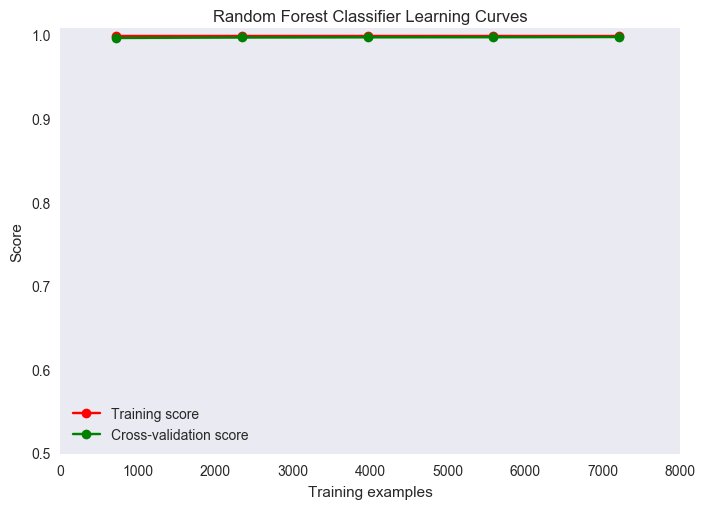

CPU times: user 2min 11s, sys: 573 ms, total: 2min 11s
Wall time: 2min 56s


In [8]:
%%time
#random forest
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=100)
print ("Random Forest: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, randomforest, numfolds=10, numrepeats=1)))

plot_estimator_learning_curve(randomforest,"Random Forest Classifier Learning Curves")

Gradient Boosted Trees: AUC = 0.999924689344 +/- 0.000219047573118  Logloss = 0.0274081501606 +/- 0.00212172178198


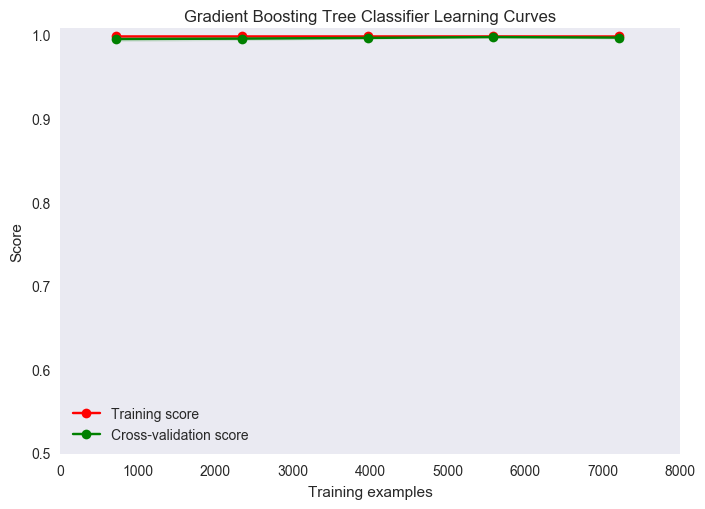

CPU times: user 1min 34s, sys: 999 ms, total: 1min 35s
Wall time: 2min 12s


In [9]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=2, random_state=0)
print("Gradient Boosted Trees: AUC = {0} +/- {1}  Logloss = {2} +/- {3}".format(*cross_validate(X_train, y_train, gbc, numfolds=10, numrepeats=1)))

plot_estimator_learning_curve(gbc,"Gradient Boosting Tree Classifier Learning Curves")

### Results
The model appears to have learned the features in the data that enable it to detect the objective audio event with **almost 100% accuracy**.

Next possible step may be to see if simplifying the layers will still provide a similar result.

# Test on an Unseen Data Set
The ```161225-002_16bit-part-0.wav-fft.csv``` data was not used in the training or validation of the model. This data containes positive and negative labels.

Test Accuracy: 0.998732078416
Test AUC: 0.997790084992
Test logloss: 0.0300125571039


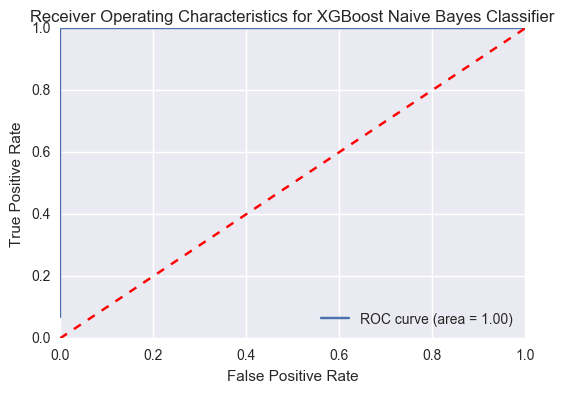

In [13]:
# fft_compressed_file = fft_directory+'161225-001_16bit-part-9.wav-fft.csv.gz'
# fft_response_file = fft_directory+'161225-001_16bit-part-9.wav-fft.csv.gz-response.csv'

fft_compressed_file = fft_directory+'161225-002_16bit-part-0.wav-fft.csv.gz'
fft_response_file = fft_directory+'161225-002_16bit-part-0.wav-fft.csv.gz-response.csv'

fft_data = pd.read_csv(fft_compressed_file).astype(np.float32)
fft_response = pd.read_csv(fft_response_file).astype(np.int)['response']

X = pd.DataFrame(fft_data)
y_pred = gbc.predict(X)
probabilities = gbc.predict_proba(X)
score = metrics.accuracy_score(y_true=fft_response, y_pred=y_pred)
print('Test Accuracy:', score)

score = evaluate(gbc, X, fft_response)
print('Test AUC:', score[0])
print('Test logloss:', score[1])

plotROC(y_pred, probabilities=probabilities, title='XGBoost Naive Bayes Classifier')

### Results
The model has performed very well on this unseen data set giving similar accuracy obtained during training.

# Test on an Unseen Data Set with All Negative Labels
The ```161225-000_16bit-part-0.wav-fft.csv``` data was not used in training the model and all observations have negative response labels.

In [14]:
fft_compressed_file = fft_directory+'161225-000_16bit-part-0.wav-fft.csv.gz'
fft_response_file = fft_directory+'161225-000_16bit-part-0.wav-fft.csv.gz-response.csv'

fft_data = pd.read_csv(fft_compressed_file).astype(np.float32)
fft_response = pd.read_csv(fft_response_file).astype(np.int)['response']

X = pd.DataFrame(fft_data)
y_pred = gbc.predict(X)
probabilities = gbc.predict_proba(X)
score = metrics.accuracy_score(y_true=fft_response, y_pred=y_pred)
print('Test Accuracy:', score)

Test Accuracy: 1.0


### Results
The model has performed very well on this unseen data set with **100% accuracy**.

# Utility for Loading a Saved Model

In [12]:
from keras.models import load_model
import tensorflow as tf
tf.python.control_flow_ops = tf

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('audio_detection.h5')

ImportError: No module named keras.models